In [46]:
# Import required libraries for fitting and clustering analysis
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.stats as ss
from scipy.optimize import curve_fit
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import RobustScaler, StandardScaler, MinMaxScaler


In [47]:
# Read dataset using pandas
data_url = 'https://raw.githubusercontent.com/faadeola/us-airline-analysis/main/air_traffic_data.csv'
airline = pd.read_csv(data_url)

# Display first 10 row of the data
airline.head(10)

,Year,Month,Dom_Pax,Int_Pax,Pax,Dom_Flt,Int_Flt,Flt,Dom_RPM,Int_RPM,RPM,Dom_ASM,Int_ASM,ASM,Dom_LF,Int_LF,LF
0,2003,1,"43,032,450","4,905,830","47,938,280","785,160","57,667","842,827","36,211,422","12,885,980","49,097,402","56,191,300","17,968,572","74,159,872",64.44,71.71,66.20
1,2003,2,"41,166,780","4,245,366","45,412,146","690,351","51,259","741,610","34,148,439","10,715,468","44,863,907","50,088,434","15,587,880","65,676,314",68.18,68.74,68.31
2,2003,3,"49,992,700","5,008,613","55,001,313","797,194","58,926","856,120","41,774,564","12,567,068","54,341,633","57,592,901","17,753,174","75,346,075",72.53,70.79,72.12
3,2003,4,"47,033,260","4,345,444","51,378,704","766,260","55,005","821,265","39,465,980","10,370,592","49,836,572","54,639,679","15,528,761","70,168,440",72.23,66.78,71.02
4,2003,5,"49,152,352","4,610,834","53,763,186","789,397","55,265","844,662","41,001,934","11,575,026","52,576,960","55,349,897","15,629,821","70,979,718",74.08,74.06,74.07
5,2003,6,"52,209,516","5,411,504","57,621,020","798,351","58,225","856,576","44,492,972","13,918,185","58,411,157","56,555,517","17,191,579","73,747,096",78.67,80.96,79.20
6,2003,7,"55,810,773","6,191,120","62,001,893","831,619","62,957","894,576","48,321,924","15,516,794","63,838,718","59,617,048","18,701,759","78,318,807",81.05,82.97,81.51
7,2003,8,"53,920,973","6,272,332","60,193,305","830,737","63,760","894,497","46,982,527","15,906,430","62,888,957","59,634,190","19,144,885","78,779,075",78.78,83.08,79.83
8,2003,9,"44,213,408","4,824,596","49,038,004","781,804","54,017","835,821","36,819,820","13,570,889","50,390,709","54,973,852","17,820,478","72,794,329",66.98,76.15,69.22
9,2003,10,"49,944,931","4,920,822","54,865,753","818,308","54,272","872,580","41,480,412","13,447,446","54,927,858","58,001,020","17,694,417","75,695,437",71.52,76.00,72.56


In [48]:
# Rename columns for clarity
airline = airline.rename(columns={
                                  'Pax' : 'Total Passengers', 'Dom_Flt' : 'Domestic flight', 'Dom_Pax' : 'Domestic pax',
                                  'Int_Pax' : 'International pax', 'Int_Flt' : 'International flight', 'Flt' : 'Total flight',
                                  'RPM' : 'Revenue per Miles', 'ASM' : 'Available Seat per Miles', 'Dom_LF' : 'Domestic Load Factor',
                                  'Int_LF' : 'International Load Factor', 'LF' : 'Total Load Factor', 'Int_RPM' : 'International RPM',
                                  'Dom_ASM' : 'Domestic ASM'
                                })

# Set specific column to appropriate data type
col_to_convert = ['Domestic pax', 'International pax', 'Total Passengers', 'Domestic flight', 'International flight', 'Total flight',
                   'Domestic RPM', 'International RPM', 'Revenue per Miles', 'Available Seat per Miles', 'Domestic ASM', 'International ASM']

# Set specific column to type int
for col in col_to_convert:
    if col in airline.columns:
        airline[col] = airline[col].str.replace(',','').astype(int)

In [49]:
# Extract column of interest back to dataset
columns_airline = ['Year', 'Total Passengers', 'Total flight', 'Revenue per Miles', 'Available Seat per Miles', 'Total Load Factor']
airline = airline[columns_airline]

In [50]:
# Since Year 2023 does not have complete 12 months data, remove it
airline = airline[airline['Year'] != 2023]

In [51]:
'''
Reduce interested columns to fraction in million
'''
# get list of columns to reduce
reduced_columns = ['Total Passengers', 'Revenue per Miles', 'Available Seat per Miles']

# Perform reduction
for col in reduced_columns:
    if col in airline.columns:
        airline[col] = airline[col]/1000000 

# Ensure columns and set to numeric      
for col in airline.columns:
    airline[col] = pd.to_numeric(airline[col])

In [52]:
''' 
Display information about the data:
columns, count of cell that are not empty (non-null) and the data type of each column
'''
print(airline.info(), end='\n\n')

# View basic statistics about the dataset
print(airline.describe().round(2))

<class 'pandas.core.frame.DataFrame'>
Index: 240 entries, 0 to 239
Data columns (total 6 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Year                      240 non-null    int64  
 1   Total Passengers          240 non-null    float64
 2   Total flight              240 non-null    int64  
 3   Revenue per Miles         240 non-null    float64
 4   Available Seat per Miles  240 non-null    float64
 5   Total Load Factor         240 non-null    float64
dtypes: float64(4), int64(2)
memory usage: 13.1 KB
None

          Year  Total Passengers  Total flight  Revenue per Miles  \
count   240.00            240.00        240.00             240.00   
mean   2012.50             62.02     773513.60              67.97   
std       5.78             12.06     117076.67              15.10   
min    2003.00              3.01     222280.00               2.91   
25%    2007.75             57.45     730990.25             

In [53]:
def plot_histogram(col):

    '''
    Create an histogram plot for any specified column
    '''
    
    fig, ax = plt.subplots(dpi=144)

    # The kde (kernel density estimate) argument set to True shows shape of the distribution on the plot
    sns.histplot(col, bins=15, color='blue', edgecolor='black', kde=True)
    
    # Draw a vertical line on the mean and median point of the specified column
    plt.axvline(col.mean(), color='red', lw=1.5, ls='--', label= f'Mean: {col.mean():.2f}')
    plt.axvline(col.median(), color='orange', lw=1, ls='-', label= f'Median: {col.median():.2f}')
    
    # Annotate skewness and kurtosis value of distribution
    plt.annotate(f'Skewness: {ss.skew(col):.2f}', 
                 xy=(col.min()-2, (col.max() - col.min() + col.min()))
                )
    
    plt.annotate(f'Kurtosis: {ss.kurtosis(col, fisher=False):.2f}', 
                 xy=(col.min()-2, (col.max() - col.min() + col.min() - np.random.randint(5,10,1)))
                )
    
    plt.annotate(f'Standard Dev.: {np.std(col):.2f}', 
                 xy=(col.min()-2, (col.max() - col.min() + col.min() - np.random.randint(12,20,1)))
                )
    
    # Set plot attributes (label, title and ticks)
    plt.xlabel(col.name, labelpad=10, fontsize=10)
    plt.ylabel('Frequency', labelpad=10, fontsize=10)
    plt.title(f'Histogram of {col.name}', fontsize=10, fontweight='bold', pad=16, loc='center')
    ax.tick_params(axis='both', labelsize=8)
    plt.legend(loc='upper left')
    plt.grid(axis='y', alpha=0.3)
    plt.show()
    return

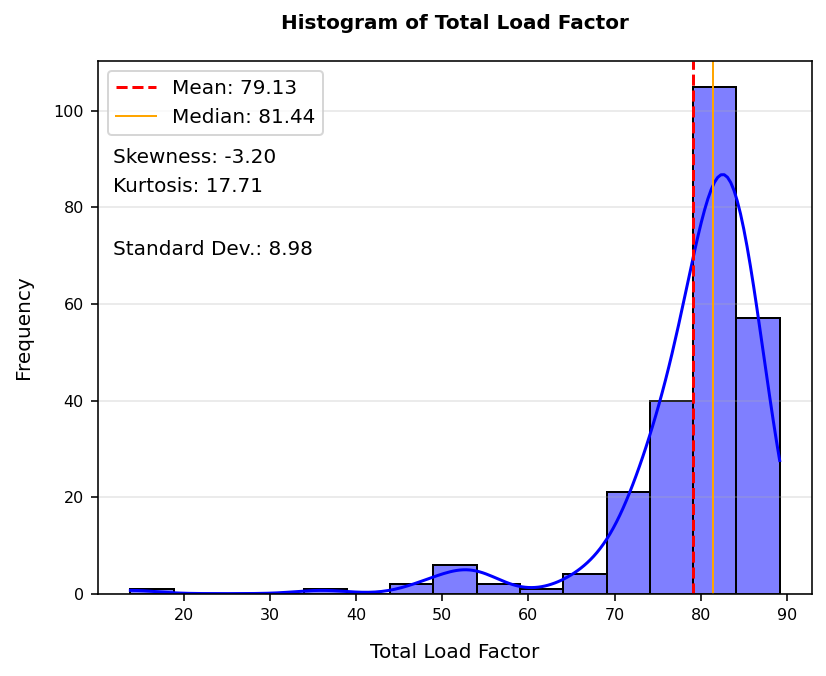

In [54]:
plot_histogram(airline['Total Load Factor'])

In [55]:
def plot_scatter(x_col,y_col):
    '''
    Create a scatter plot between two columns
    '''

    fig, ax = plt.subplots(dpi=144)
    plt.scatter(x_col,y_col, color='red', marker='o', alpha=0.4, label=y_col.name)
    
    # Set the plot attributes (labels, title, grid and ticks)
    plt.xlabel(x_col.name, labelpad=10, fontsize=10)
    plt.ylabel(f'{y_col.name}', labelpad=10, fontsize=10)
    plt.grid(axis='both', color='lightgray', alpha=0.3)
    ax.tick_params(axis='both', labelsize=8)
    
    plt.title(f'Scatter plot of {x_col.name} vs {y_col.name}', fontsize=10, fontweight='bold', pad=16, loc='center')
    plt.tight_layout()
    plt.legend()

    plt.show()
    return

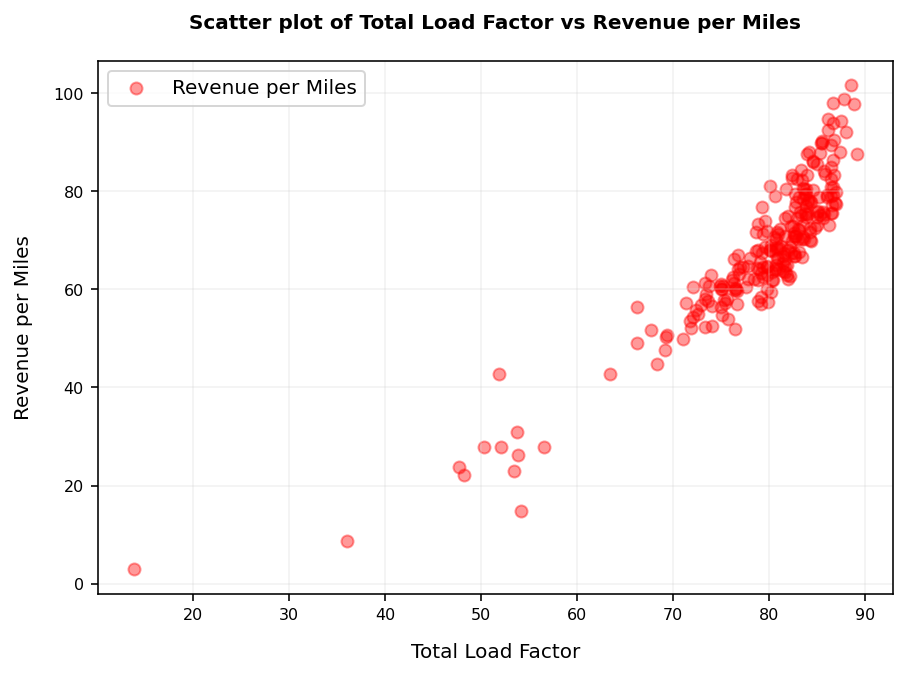

In [56]:
plot_scatter(airline['Total Load Factor'],  airline['Revenue per Miles'])

In [57]:
def plot_corr_hmap(data):
    '''
    Plot the heatmap for the gym dataframe 
    using the Seaborn Library and Pearson's method
    '''
    # Get correlation values of the dataset
    data_corr = data.corr(method='pearson', numeric_only=True)
    
    # Set mask to hide the upper repetition of data in the heatmap
    hmask = np.triu(np.ones_like(data_corr))

    # Plotting the heatmap
    plt.figure(figsize=(14,8),dpi=144)
    sns.heatmap(data_corr, cmap='coolwarm', annot=True, lw=1.5, mask=hmask, vmin=-1, vmax=1)
    
    # Set plot attributes
    plt.title(f'Heatmap of Airline Dataset', fontsize=14, fontweight='bold', pad=16, loc='center')
    plt.tick_params(axis='both', labelsize=12)

    plt.show()
    return

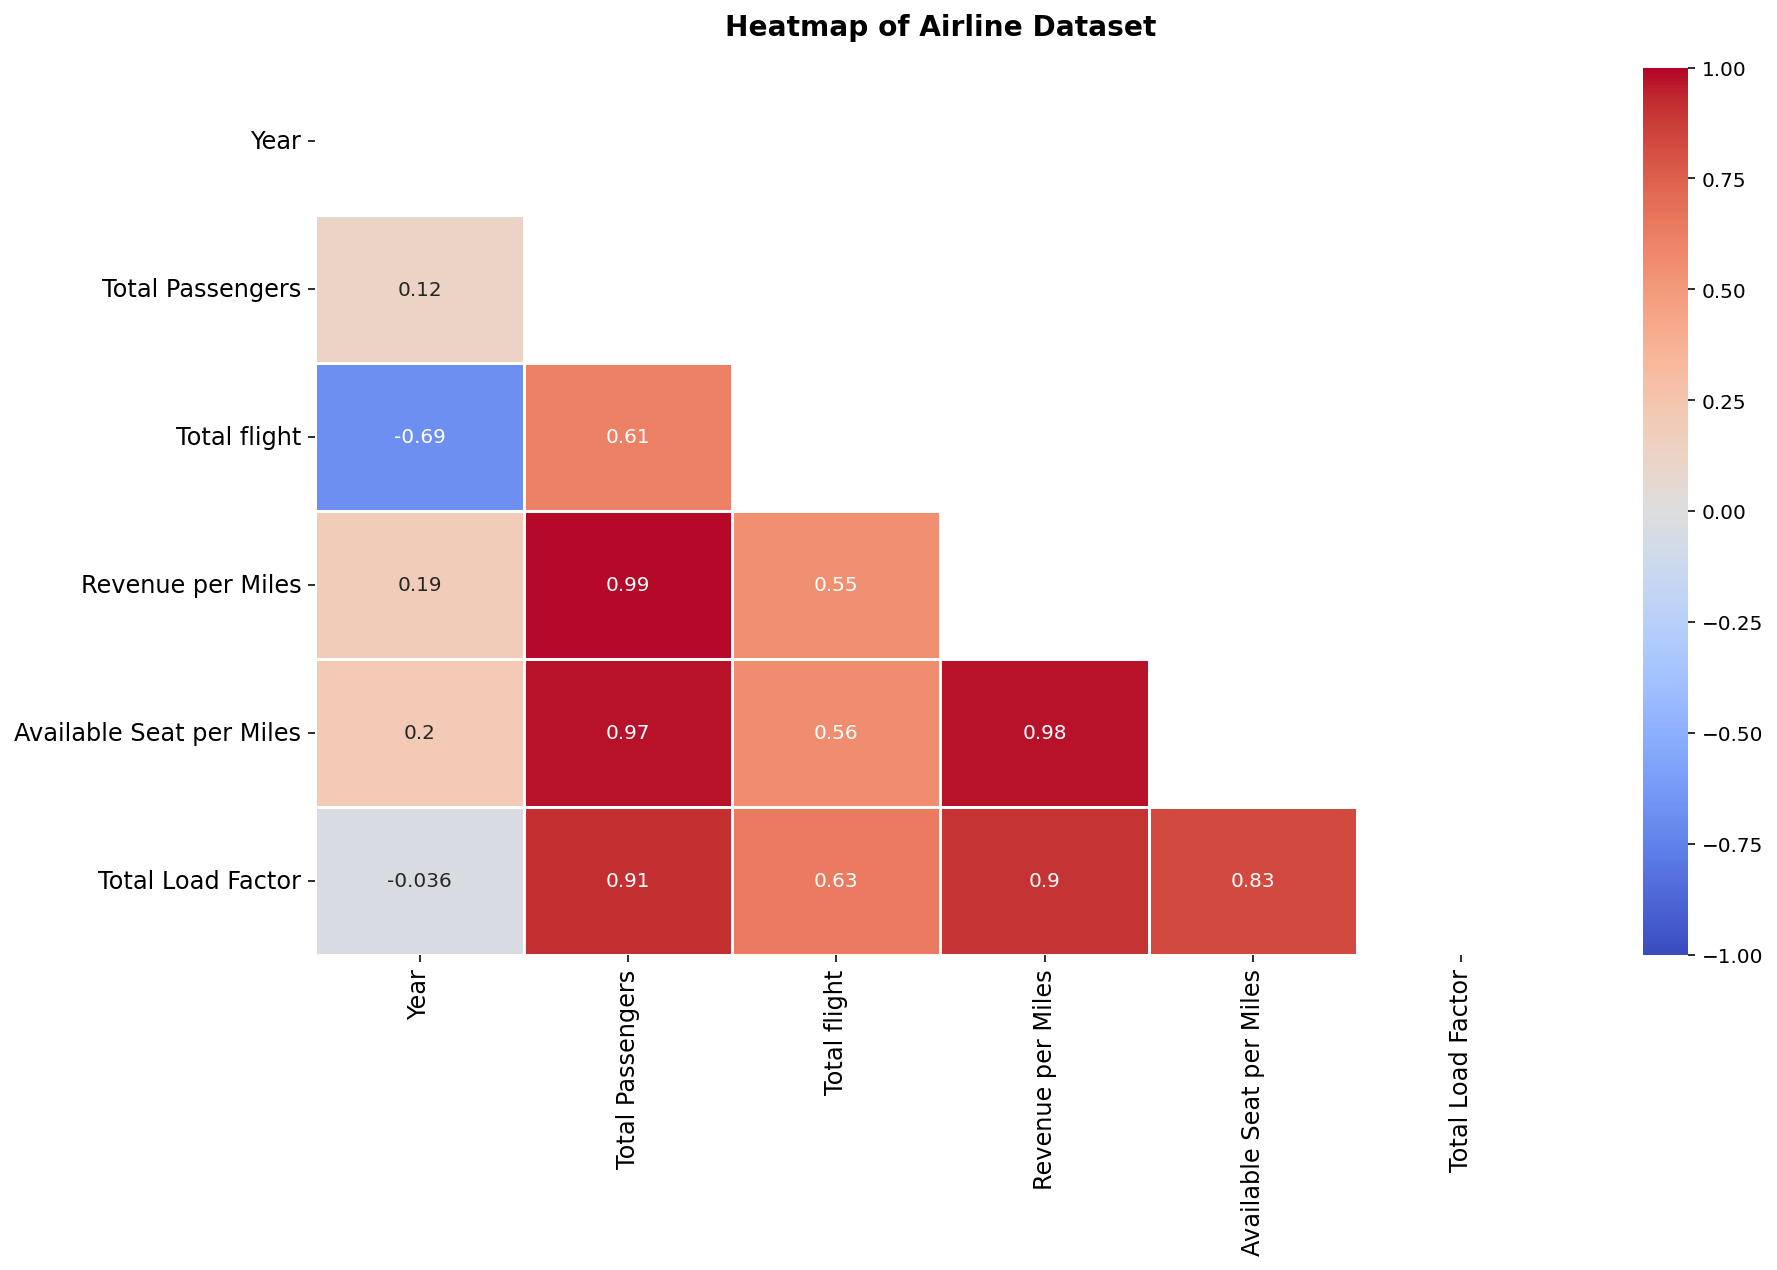

In [58]:
# Display heatmap of correlation
plot_corr_hmap(airline)

In [59]:
# Define logistic function
def logistic(t, n0, g, t0):
    """
    Calculates the logistic function with scale factor n0 and growth rate g
    """
    
    f = n0 / (1 + np.exp(-g*(t - t0)))
    
    return f 

In [60]:
def fit_data(x_col, y_col):
    '''
    Perform normalization, fitting and parameters for fitting
    '''
    scaler = MinMaxScaler()
    x_value = x_col.values.reshape(-1,1)
    y_value = y_col.values.reshape(-1,1)
    
    # Normalize x and y values
    norm_x =  scaler.fit_transform(x_value).flatten()
    norm_y =  scaler.fit_transform(y_value).flatten()
    
    # Give some intial guess for logistic fitting
    p, cov = curve_fit(logistic, norm_x, norm_y,
                  p0=(np.max(norm_y), 0.05, 5), maxfev = 5000)
    sigma = np.sqrt(np.diag(cov))
    
    print('Values for Logistic Fit:')
    print(f"N0 = {p[0]:g} +/- {sigma[0]:g}")
    print(f"g = {p[1]:.2f} +/- {sigma[1]:.2f}")
    print(f"t0 = {p[2] + np.median(x_col):.2f} +/- {sigma[2]:.2f}")
    

    # Generate points to make smooth curve
    x_smooth = np.linspace(norm_x.min(),norm_x.max(),len(x_col))
    y_smooth = logistic(x_smooth, *p)
    
    # Revert normalized data to original and add the values from fitting function to a new column in dataset
    airline[f'{x_col.name} Copy'] = scaler.inverse_transform(x_smooth.reshape(-1,1)).flatten()
    airline['Logistic Fit'] = scaler.inverse_transform(y_smooth.reshape(-1,1)).flatten()
    
    return

In [61]:
# Display curve fit parameters
fit_data(airline['Total Load Factor'], airline['Revenue per Miles'])

Values for Logistic Fit:
N0 = 653.471 +/- 122782
g = 2.54 +/- 0.45
t0 = 85.05 +/- 74.80


/var/folders/0m/xqybp8vx5_92dx6xq43g1_sw0000gn/T/ipykernel_8668/705924169.py:7: RuntimeWarning: overflow encountered in exp
  f = n0 / (1 + np.exp(-g*(t - t0)))


In [62]:
def plot_fitted_data():
    '''
    Plot logistic fit on scatter plot of Total Load Factor vs Revenue per Miles
    '''
    
    
    fig, ax = plt.subplots(dpi=144)
    
    # Get correlation values of the dataset
    plt.scatter(airline['Total Load Factor'], airline['Revenue per Miles'], lw=2, label ='Revenue per Miles')
    plt.plot(airline['Total Load Factor Copy'], airline['Logistic Fit'], lw=2, label ='Logistic Fit', color='black')
    
    # Set the plot attributes (labels, title, grid and ticks)
    plt.xlabel('Total Load Factor', labelpad=10, fontsize=10)
    plt.ylabel('Revenue per Miles (x1000000)', labelpad=10, fontsize=10)
    plt.grid(axis='both', color='lightgray', alpha=0.3)
    ax.tick_params(axis='both', labelsize=8)
    
    plt.tight_layout()
    plt.legend()
    #plt.savefig(f'{x_col.name} vs {y_col.name}.png')

    plt.show()
    return

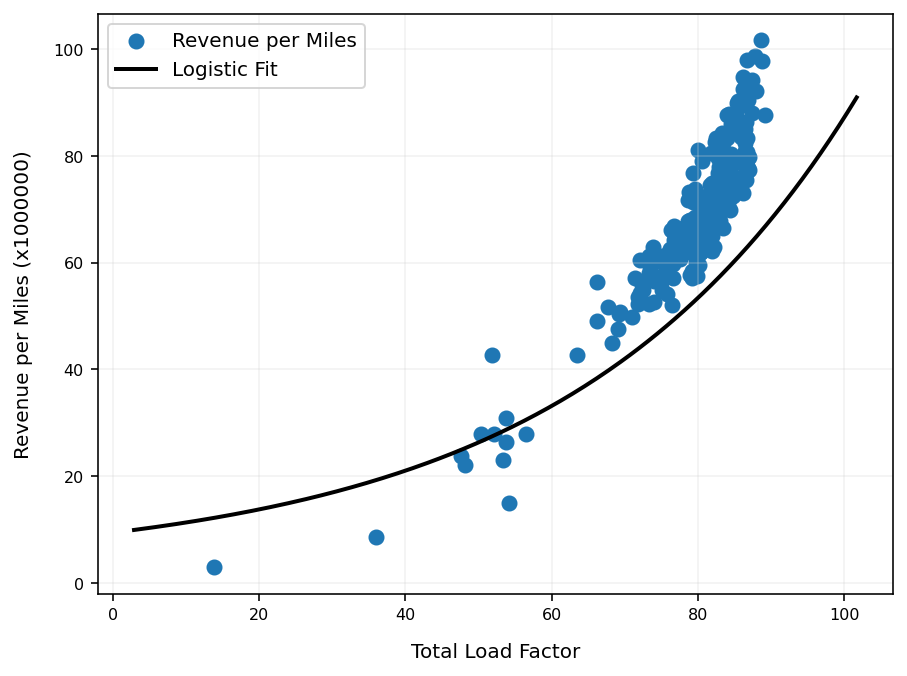

In [63]:
# Dsiplay fitted curve on the scatter plot
plot_fitted_data()

In [64]:
def fit_predict(x_col,y_col):
    # Extrapolating of the Data into the next 8 years using logistic function

    # Normalize data
    scaler = MinMaxScaler()
    x_value = x_col.values.reshape(-1,1)
    y_value = y_col.values.reshape(-1,1)

    # Normalize x and y values
    norm_x =  scaler.fit_transform(x_value).flatten()
    norm_y =  scaler.fit_transform(y_value).flatten()

    # Give some intial guess for logistic fitting
    p, cov = curve_fit(logistic, norm_x, norm_y,
                    p0=(np.max(norm_y), 0.05, 5), maxfev = 5000)
    sigma = np.sqrt(np.diag(cov))
        
    x_predict = np.linspace(norm_x.min(),1.2,len(x_col))
    
    #x_predict = np.arange(norm_x.min(),1.2,5)
    y_predict = logistic(1.2-x_predict, *p)
    
    # take exact dataset length for normal random samples for each parameter
    sample_params = ss.multivariate_normal.rvs(mean=p, cov=cov, size=len(x_col))

    # standard deviation of all possible parameter sampling
    y_predict_sd = np.array([np.std(logistic(pred-norm_x.min(), *sample_params.T))for pred in x_predict])  # note the transpose
    
    
    # Revert normalized data to original and add the values from fitting function to a new column in dataset
    airline['Extrapolated Load Factor'] = scaler.inverse_transform(x_predict.reshape(-1,1)).flatten()
    airline['Revenue Predict'] = scaler.inverse_transform(y_predict.reshape(-1,1)).flatten()
    
    # Show first 5 extrapolated Load Factor predicitions
    for k in range(5):
      load_factor = airline['Extrapolated Load Factor'].iloc[k] * 100
      predicted_revenue = airline['Revenue Predict'].iloc[k]
      
      # Print first 5 results
      print(f"Predicted Revenue per Miles at Total Load Factor {load_factor:.2f}%: {predicted_revenue:g}")
        
  
    
    return 

In [65]:
# Display predictions
fit_predict(airline['Total Load Factor'], airline['Revenue per Miles'])

Predicted Revenue per Miles at Total Load Factor 290.79%: 148.96
Predicted Revenue per Miles at Total Load Factor 340.40%: 147.117
Predicted Revenue per Miles at Total Load Factor 390.02%: 145.297
Predicted Revenue per Miles at Total Load Factor 439.63%: 143.5
Predicted Revenue per Miles at Total Load Factor 489.25%: 141.726


/var/folders/0m/xqybp8vx5_92dx6xq43g1_sw0000gn/T/ipykernel_8668/705924169.py:7: RuntimeWarning: overflow encountered in exp
  f = n0 / (1 + np.exp(-g*(t - t0)))


In [66]:
# Normalize and back scale values for clustering
airline_cluster = airline[['Total Load Factor', 'Total flight']].copy()
scaler = RobustScaler()
norm = scaler.fit_transform(airline_cluster)
reversed_norm = scaler.inverse_transform(norm)

In [96]:
def one_silhoutte_inertia(n, xy):
    """ 
    Calculates the silhoutte score and WCSS for n clusters 
    """
    # set up the clusterer with the number of expected clusters
    kmeans = KMeans(n_clusters=n, n_init=20)
    
    # Fit the data
    kmeans.fit(xy)
    labels = kmeans.labels_
    
    # calculate the silhoutte score
    score = silhouette_score(xy, labels)
    inertia = kmeans.inertia_

    return score, inertia

In [97]:
wcss = []
best_n, best_score = None, -np.inf
for n in range(2, 11):  # 2 to 10 clusters
    score, inertia = one_silhoutte_inertia(n, norm)
    wcss.append(inertia)
    if score > best_score:
        best_n = n
        best_score = score
    print(f"{n:2g} clusters silhoutte score = {score:.2f}")

print(f"Best number of clusters = {best_n:2g} with best score = {best_score:.2f} ")

 2 clusters silhoutte score = 0.78
 3 clusters silhoutte score = 0.44
 4 clusters silhoutte score = 0.40
 5 clusters silhoutte score = 0.41
 6 clusters silhoutte score = 0.40
 7 clusters silhoutte score = 0.40
 8 clusters silhoutte score = 0.42
 9 clusters silhoutte score = 0.39
10 clusters silhoutte score = 0.41
Best number of clusters =  2 with best score = 0.78 


In [73]:
def plot_elbow_method(min_k, max_k, wcss, best_n):
    """
    Plots the elbow method between min_k and max_k
    """
    fig, ax = plt.subplots(dpi=144)
    ax.plot(range(min_k, max_k + 1), wcss, 'kx-')
    ax.scatter(best_n, wcss[best_n-min_k], marker='o', color='red', facecolors='none', s=50, label= f'Best number of cluster:{best_n:2g}')
    
    # Set plot attributes
    ax.set_xlabel('k')
    ax.set_xlim(min_k, max_k)
    plt.title('Elbow plot diagram', fontsize=10, fontweight='bold', pad=14, loc='center')
    ax.tick_params(axis='both', labelsize=8)
    plt.legend()
    ax.set_ylabel('WCSS')
    plt.show()
    return

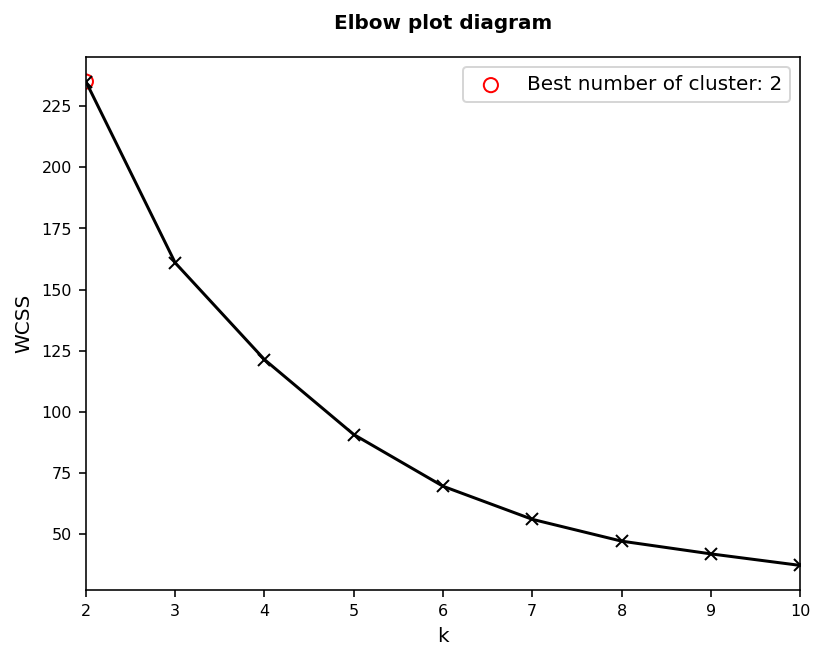

In [74]:
plot_elbow_method(2, 10, wcss, best_n)

In [89]:
def plot_air_clusters(labels, xy, xkmeans, ykmeans, centre_labels):
    """
    Plots clustered data as a scatter plot with determined centres shown
    """
    
    from matplotlib.colors import ListedColormap
    colours = plt.cm.Set1(np.linspace(0, 1, len(np.unique(labels))))
    cmap = ListedColormap(colours)
    
    fig, ax = plt.subplots(dpi=144)
    s = ax.scatter(xy[:, 0], xy[:, 1], c=labels, cmap='viridis', marker='o', label='Data')
    ax.scatter(xkmeans, ykmeans, c=centre_labels, cmap='coolwarm', marker='x', s=120, label='Estimated Centres')

    cbar = fig.colorbar(s, ax=ax)
    cbar.set_ticks(np.unique(labels))
    
    # Set plot attributes
    ax.legend()
    ax.set_xlabel('Total Load Factor')
    ax.set_ylabel('Total Flight')
    ax.tick_params(axis='both', labelsize=8)
    #ax.set_yscale('log')
    plt.show()
    return

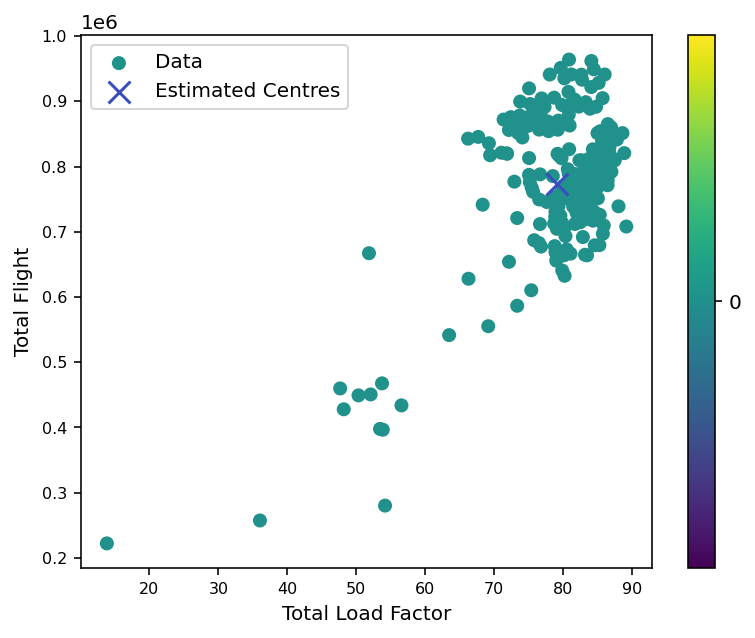

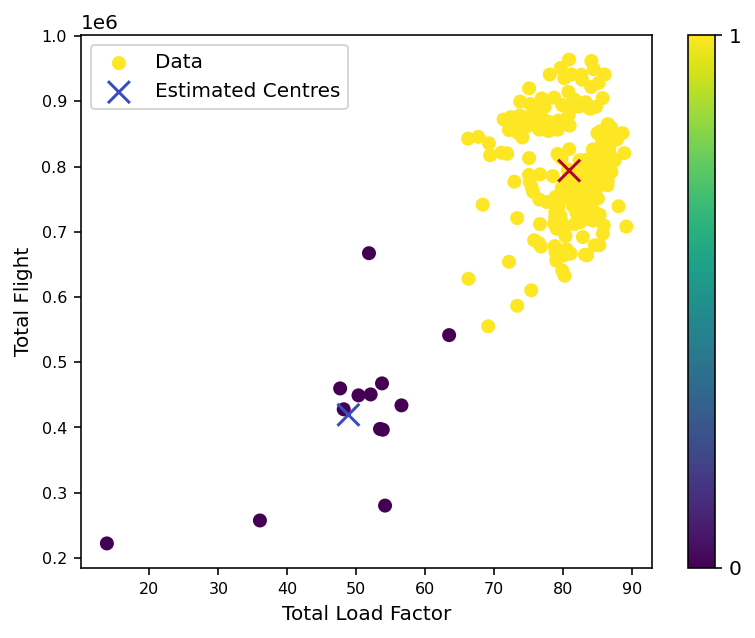

In [90]:
for k in range(1, 3):
    kmeans = KMeans(n_clusters=k, n_init=20)
    kmeans.fit(norm)     # fit done on x,y pairs
    labels = kmeans.labels_
    
    # the estimated cluster centres
    cen = scaler.inverse_transform(kmeans.cluster_centers_)
    xkmeans = cen[:, 0]
    ykmeans = cen[:, 1]
    cenlabels = kmeans.predict(kmeans.cluster_centers_)
    
    # Call plot function
    plot_air_clusters(labels, reversed_norm, xkmeans, ykmeans, cenlabels)

In [205]:
def clust_predict(predicted_points):
    """
    Set up cluster predictions
    """
    from matplotlib.colors import ListedColormap

    x = airline_cluster.iloc[:,0].values
    y = airline_cluster.iloc[:,1].values

    # KMeans with desired number of cluster
    kmeans = KMeans(n_clusters=2, n_init=20)

    # Fit the data
    kmeans.fit(airline_cluster)

    # Predict clusters for data and predicted points
    no_clust = kmeans.predict(airline_cluster)
    pred_no_clust = kmeans.predict(predicted_points)

    # Store predicted point in an array to hold all rows and different columns
    predicted_points_0 = predicted_points[:,0]
    predicted_points_1 = predicted_points[:,1]

    # creating a custom colormap for plotting
    colours = plt.cm.Set1(np.linspace(0, 1, len(np.unique(no_clust))))
    cmaps = ListedColormap(colours)

    return x, y, predicted_points_0, predicted_points_1, cmaps, no_clust, pred_no_clust

In [210]:
def plot_pred_points(predicted_points):
    """
    Plots predicted points on the scatter plot
    """

    # Call function to unpack parameters for plotting new points
    xpoints, ypoints, point_1, point_2, cmap, nclust, nclust_predict = clust_predict(predicted_points)

    fig, ax = plt.subplots(dpi=144)

    s = ax.scatter(xpoints, ypoints, c=nclust, cmap=cmap, marker='o', label='Data')
    
    # Define colors to label predicted points
    colors = ['grey', 'green', 'blue']
    
    # Loop through to place points label on plot
    for i,(x,y) in enumerate(predicted_points):
      ax.scatter(x, y, color=colors[i], marker='x',  s=120, label=f'Predicted points {i+1}') 
      ax.text(x, y, f'P{i+1}', fontsize=10, weight='bold', zorder=2)

    cbar = fig.colorbar(s, ax=ax)
    cbar.set_ticks(np.unique(nclust))

    # Set plot attributes
    ax.legend()
    ax.set_xlabel('Total Load Factor')
    ax.set_ylabel('Total Flight')
    ax.tick_params(axis='both', labelsize=8)
    plt.show()
    return

/opt/anaconda3/lib/python3.12/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but KMeans was fitted with feature names
  warnings.warn(


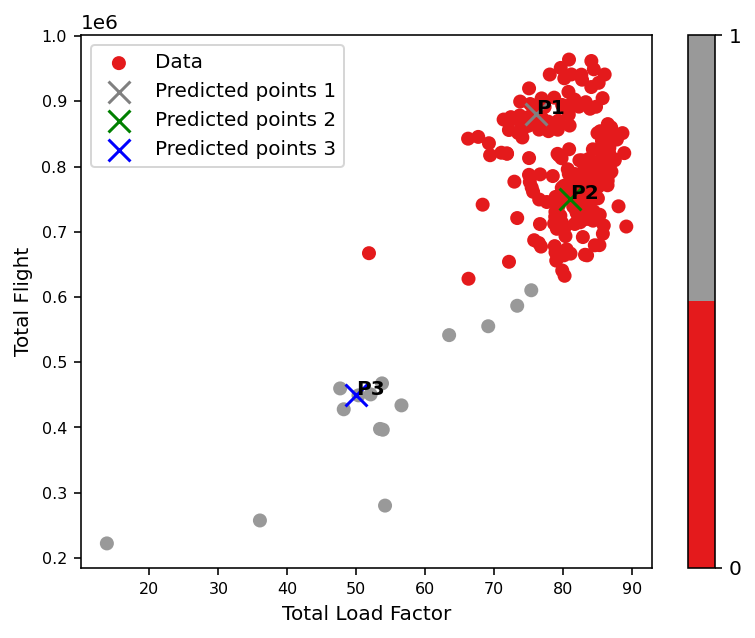

In [212]:
# Display plot of some predicted points
plot_pred_points(np.array([[76, 0.88e6], [81, 0.75e6], [50,0.45e6]]))